# CSE 6240 HW 1
# Xianghui Gu, xgu72, 903248583

## 1: Processing text to create design matrices

### 1.0 Read csv and clean data

In [1]:
import pandas as pd   
from bs4 import BeautifulSoup 
import nltk
import re

train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [2]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "html.parser").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [3]:
from nltk.corpus import stopwords
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size
clean_train_reviews = []
for i in range( 0, num_reviews ):                                                                 
    clean_train_reviews.append( review_to_words( train["review"][i] ))

### 1.1 X_counts

In [52]:
# print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_counts = vectorizer.fit_transform(clean_train_reviews)


### 1.2 X_binary

In [5]:
import copy
X_binary = copy.deepcopy(X_counts)
X_binary[X_binary > 0] = 1

### 1.3 X_tfidf

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = TfidfTransformer(smooth_idf=False)
X_tfidf = vectorizer.fit_transform(X_counts)

### 1.4 X_binary_imbalance

In [42]:
import numpy as np
from scipy import sparse
sentiment = train["sentiment"]
rows = sentiment[sentiment==1].index
np.random.seed(0)
drop_rows = np.random.choice(rows, int(0.75*len(rows)),replace=False)
imbalance = np.delete(X_counts.toarray(),drop_rows,0)
X_binary_imbalance = sparse.csr_matrix(imbalance.tolist())
sentiment_imbalance = np.delete(sentiment.values,drop_rows,0)

## 2: Feature space similarity experiment

### 2.1 Distance function

In [100]:
import numpy as np
def dist(X, i, j, distance_function='Euclidean'):
    X = X.toarray()
    return np.linalg.norm(X[i]-X[j])

### 2.2 Topk function

In [8]:
import sklearn.metrics.pairwise as smp
def topk(X,k):
    distance = smp.pairwise_distances(X,n_jobs=1)
    
    lowerhalf = np.tril(distance,-1).T
    lowerhalf[lowerhalf == 0] = float("inf")

    ind = np.argpartition(lowerhalf.flatten(), k)[:k]
    matind = np.unravel_index(ind, lowerhalf.shape)
    result_list = np.dstack((matind[0],matind[1],lowerhalf[matind]))[0]

    return sorted([(int(tu[0]),int(tu[1]),tu[2]) for tu in result_list], key=lambda x:x[2])
    


In [81]:
def printtopk(x,k):
    temp = topk(x,k)
    for tu in temp:
        print("Index: ",tu[0],", ",tu[1])
        print("Distance: ",tu[2])
        print("Review",tu[0],"with label",sentiment[tu[0]],": ",clean_train_reviews[tu[0]][:20])
        print("Review",tu[1],"with label",sentiment[tu[1]],": ",clean_train_reviews[tu[1]][:20])
    


#### 2.2.1 X_counts results

In [110]:
printtopk(X_counts,10)

Index:  2052 ,  20915
Distance:  1.0
Review 2052 with label 1 :  atlantis much better
Review 20915 with label 1 :  atlantis much better
Index:  11876 ,  21854
Distance:  1.0
Review 11876 with label 0 :  big fan rom coms bes
Review 21854 with label 0 :  big fan rom coms bes
Index:  17927 ,  23442
Distance:  1.0
Review 17927 with label 1 :  liked stanley iris m
Review 23442 with label 1 :  liked stanley iris m
Index:  7758 ,  18697
Distance:  1.0
Review 7758 with label 1 :  kurt russell best ma
Review 18697 with label 1 :  kurt russell best ma
Index:  7663 ,  11331
Distance:  1.0
Review 7663 with label 1 :  saw theater fell cha
Review 11331 with label 1 :  saw theater fell cha
Index:  7245 ,  16635
Distance:  1.0
Review 7245 with label 1 :  really surprised mov
Review 16635 with label 1 :  really suprised movi
Index:  14007 ,  15296
Distance:  1.41421356237
Review 14007 with label 1 :  full length feature 
Review 15296 with label 1 :  full length feature 
Index:  3217 ,  13530
Distance: 

#### 2.2.2 X_binary results

In [111]:
printtopk(X_binary,10)

Index:  7663 ,  11331
Distance:  1.0
Review 7663 with label 1 :  saw theater fell cha
Review 11331 with label 1 :  saw theater fell cha
Index:  2052 ,  20915
Distance:  1.0
Review 2052 with label 1 :  atlantis much better
Review 20915 with label 1 :  atlantis much better
Index:  11876 ,  21854
Distance:  1.0
Review 11876 with label 0 :  big fan rom coms bes
Review 21854 with label 0 :  big fan rom coms bes
Index:  7758 ,  18697
Distance:  1.0
Review 7758 with label 1 :  kurt russell best ma
Review 18697 with label 1 :  kurt russell best ma
Index:  7245 ,  16635
Distance:  1.0
Review 7245 with label 1 :  really surprised mov
Review 16635 with label 1 :  really suprised movi
Index:  17927 ,  23442
Distance:  1.0
Review 17927 with label 1 :  liked stanley iris m
Review 23442 with label 1 :  liked stanley iris m
Index:  5930 ,  8651
Distance:  1.0
Review 5930 with label 0 :  movie beautiful scen
Review 8651 with label 0 :  movie beautiful scen
Index:  3217 ,  13530
Distance:  1.0
Review 32

#### 2.2.3 X_tfidf results

In [112]:
printtopk(X_tfidf,10)

Index:  6864 ,  14534
Distance:  0.0806555620545
Review 6864 with label 0 :  praised atlantis los
Review 14534 with label 0 :  praised atlantis los
Index:  17096 ,  21325
Distance:  0.13706274111
Review 17096 with label 0 :  college dorm guy kil
Review 21325 with label 0 :  college dorm guy kil
Index:  3217 ,  13530
Distance:  0.152484056832
Review 3217 with label 1 :  brothers psychokinet
Review 13530 with label 1 :  brothers psychokinet
Index:  2052 ,  20915
Distance:  0.165548384581
Review 2052 with label 1 :  atlantis much better
Review 20915 with label 1 :  atlantis much better
Index:  7758 ,  18697
Distance:  0.167674491095
Review 7758 with label 1 :  kurt russell best ma
Review 18697 with label 1 :  kurt russell best ma
Index:  7663 ,  11331
Distance:  0.179523238929
Review 7663 with label 1 :  saw theater fell cha
Review 11331 with label 1 :  saw theater fell cha
Index:  5930 ,  8651
Distance:  0.195973707
Review 5930 with label 0 :  movie beautiful scen
Review 8651 with label 

#### 2.2.4 X_binary_imbalance results

In [113]:
imbalancelist = topk(X_binary_imbalance,10)
reviews_imbalance = np.delete(np.array(clean_train_reviews),drop_rows,0)
for tu in imbalancelist:
    print("Index: ",tu[0],", ",tu[1])
    print("Distance: ",tu[2])
    print("Review",tu[0],"with label",sentiment_imbalance[tu[0]],": ",reviews_imbalance[tu[0]][:20])
    print("Review",tu[1],"with label",sentiment_imbalance[tu[1]],": ",reviews_imbalance[tu[1]][:20])

Index:  7394 ,  13656
Distance:  1.0
Review 7394 with label 0 :  big fan rom coms bes
Review 13656 with label 0 :  big fan rom coms bes
Index:  3681 ,  5376
Distance:  1.41421356237
Review 3681 with label 0 :  movie beautiful scen
Review 5376 with label 0 :  movie beautiful scen
Index:  10711 ,  13344
Distance:  1.73205080757
Review 10711 with label 0 :  college dorm guy kil
Review 13344 with label 0 :  college dorm guy kil
Index:  12680 ,  13920
Distance:  2.2360679775
Review 12680 with label 0 :  movie terrible good 
Review 13920 with label 0 :  ming merciless littl
Index:  5628 ,  12680
Distance:  2.82842712475
Review 5628 with label 0 :  comment movie imposs
Review 12680 with label 0 :  movie terrible good 
Index:  13920 ,  15157
Distance:  2.82842712475
Review 13920 with label 0 :  ming merciless littl
Review 15157 with label 0 :  rating begin express
Index:  2366 ,  13920
Distance:  2.82842712475
Review 2366 with label 0 :  characters unlikeabl
Review 13920 with label 0 :  ming m

#### 2.2.5 Discussion

The pairs are not the same given top 10. It's possibly due to difference in design matrices and difference in ways of breaking ties.

## 3. Classification Experiment

In [118]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import datasets,svm

def selectC(x,y):
    clist = []
    np.random.seed(0)
    for i in range(30):
        c = 10**np.random.uniform(-4,4)
        clf = svm.LinearSVC(C=c).fit(x, y)
        scores = cross_val_score(clf, x, y, cv=5,scoring='roc_auc')
        mean_score = scores.mean()
        clist.append((mean_score,c))
    clist.sort(reverse=True)
    return clist[0][1],clist[0][0]-clist[-1][0]

def plot_curve(fpr,tpr,roc_auc,title):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of '+title)
    plt.legend(loc="lower right")
    plt.show()

def graphGenerate(XX,y,title):
    xtrain, xtest, ytrain, ytest = train_test_split(XX, y, test_size=0.2, random_state=0)
    c,l = selectC(xtrain,ytrain)
    print("best c: ",c)
    print("lift: ", l)
    clf = svm.LinearSVC(C=c).fit(xtrain, ytrain)    
    fpr, tpr, thresholds = roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    plot_curve(fpr,tpr,roc_auc,title)
    return c,l


### 3.1 X_counts ROC with AUC(area)

best c:  0.0037381686712357584
lift:  0.0475511795684


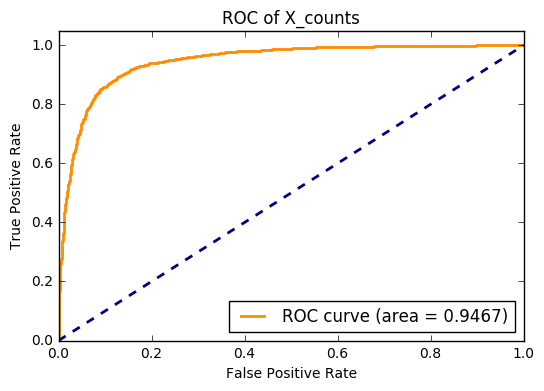

In [119]:
c1,l1 = graphGenerate(X_counts,sentiment,'X_counts')

### 3.2 X_binary ROC with AUC(area)

best c:  0.0037381686712357584
lift:  0.0483640349873


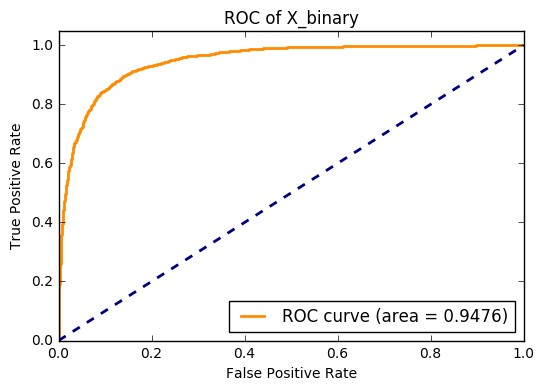

In [125]:
c2,l2 = graphGenerate(X_binary,sentiment,'X_binary')

### 3.3 X_tfidf ROC with AUC(area)

best c:  0.24504079607415993
lift:  0.0510934856786


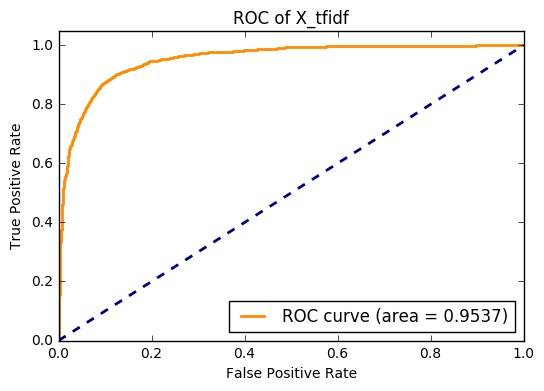

In [123]:
c3,l3 = graphGenerate(X_tfidf,sentiment,'X_tfidf')

### 3.4 X_binary_imbalance ROC with AUC(area)

best c:  0.0037381686712357584
lift:  0.0472328965778


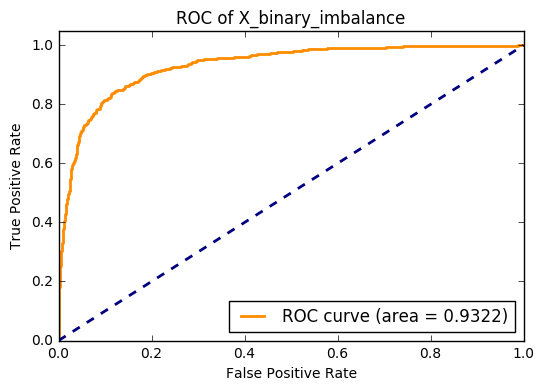

In [124]:
c4,l4 = graphGenerate(X_binary_imbalance,sentiment_imbalance,'X_binary_imbalance')

### 3.5 Kaggle score

Read data and generate test data features

In [73]:
# Read the test data
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

for i in range(0,num_reviews):
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)


X_counts Kaggle score: 0.87788

In [66]:
# Use X_counts to make sentiment label predictions
clf = svm.LinearSVC(C=c1).fit(X_counts, sentiment) 
result = clf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "X_counts.csv", index=False, quoting=3 )

X_binary Kaggle score: 0.87752

In [70]:
# Use X_binary to make sentiment label predictions
clf = svm.LinearSVC(C=c2).fit(X_binary, sentiment) 
result = clf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "X_binary.csv", index=False, quoting=3 )

X_tfidf Kaggle score: 0.87452

In [71]:
# Use X_tfidf to make sentiment label predictions
clf = svm.LinearSVC(C=c3).fit(X_tfidf, sentiment) 
result = clf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "X_tfidf.csv", index=False, quoting=3 )

X_binary_imbalance Kaggle score: 0.78412

In [72]:
# Use X_binary_imbalance to make sentiment label predictions
clf = svm.LinearSVC(C=c4).fit(X_binary_imbalance, sentiment_imbalance) 
result = clf.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "X_binary_imbalance.csv", index=False, quoting=3 )

### 3.6 Discussion

The first three methods have similar performance which excel the last one. For the training set, X_tfidf has the best performance. For the testing set, X_counts has the best performance.

As for lift in ROC-AUC, the lift for the four methods are:

In [126]:
print("X_counts: ",l1)
print("X_binary: ",l2)
print("X_tfidf: ",l3)
print("X_binary_imbalance: ",l4)

X_counts:  0.0475511795684
X_binary:  0.0483640349873
X_tfidf:  0.0510934856786
X_binary_imbalance:  0.0472328965778


## 4. Learning Curve Experiment

### 4.1 Learning curve generation

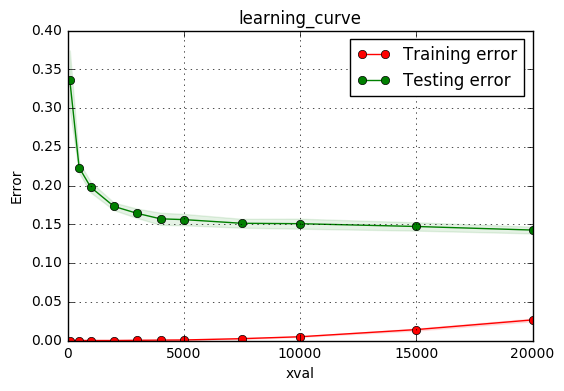

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

plt.figure()
plt.title("learning_curve")
plt.xlabel("xval")
plt.ylabel("Error")
estimator = LogisticRegression()
ranges = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
train_sizes, train_scores, test_scores = learning_curve(estimator, \
                                                        X_counts, sentiment,cv=5,\
                                                        train_sizes=ranges)
train_scores_mean = 1-np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = 1-np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Testing error")

plt.legend(loc="best")

plt.show()

### 4.2 Interpretation of the curve

The training error shows how well the model fits the data. The green line is the cross-validation error while the red line is training set error. With small training set size, the model tends to underfit; with large training set size, the model tends to overfit. Hence, at first, the testing error is much higher than training error. With increasing training instances, the error gap tends to decrease.